## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [3]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [4]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [5]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

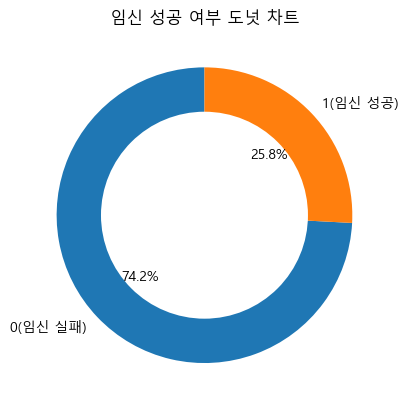

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [7]:
# '시술_유형' 변수의 값이 'IVF'에 해당 안하는 데이터 추출
IVF_train = train[train['시술_유형'] == 'IVF'] 
IVF_test = test[test['시술_유형'] == 'IVF']

# 모든 값이 결측값인 변수를 제거
IVF_train = IVF_train.dropna(axis=1, how='all')
IVF_test = IVF_test.dropna(axis=1, how='all')

train = IVF_train
test = IVF_test

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [8]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRCMWS    0.739895  0.260105  27567  9691  37258
TRDQAZ    0.751191  0.248809  28549  9456  38005
TRJXFG    0.730081  0.269919  25693  9499  35192
TRVNRY    0.736404  0.263596  25917  9277  35194
TRXQMD    0.741403  0.258597  25161  8776  33937
TRYBLT    0.727689  0.272311  26092  9764  35856
TRZKPL    0.741348  0.258652  25664  8954  34618


### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [9]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1        0        1   Total
variable                                              
만18-34세   0.674737  0.325263  67747.0  32658.0  100405
만35-37세   0.718321  0.281679  40463.0  15867.0   56330
만38-39세   0.779704  0.220296  29780.0   8414.0   38194
만40-42세   0.838043  0.161957  30431.0   5881.0   36312
만43-44세   0.878486  0.121514  10396.0   1438.0   11834
만45-50세   0.825871  0.174129   5497.0   1159.0    6656
알 수 없음    1.000000  0.000000    329.0      0.0     329


In [10]:
test['시술_당시_나이'].value_counts()

시술_당시_나이
만18-34세    35498
만35-37세    19687
만38-39세    13228
만40-42세    12911
만43-44세     4123
만45-50세     2328
알 수 없음       116
Name: count, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [11]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1    0    1  Total
variable                                     
0.0       0.666667  0.333333    8    4     12
1.0       0.500000  0.500000    2    2      4
2.0       0.809524  0.190476   17    4     21
3.0       0.762500  0.237500   61   19     80
4.0       0.759322  0.240678  224   71    295
5.0       0.753687  0.246313  511  167    678
6.0       0.747126  0.252874  715  242    957
7.0       0.765453  0.234547  904  277   1181
8.0       0.782379  0.217621  888  247   1135
9.0       0.790744  0.209256  786  208    994
10.0      0.778384  0.221616  713  203    916
11.0      0.808036  0.191964  543  129    672
12.0      0.776639  0.223361  379  109    488
13.0      0.835853  0.164147  387   76    463
14.0      0.775701  0.224299  249   72    321
15.0      0.791165  0.208835  197   52    249
16.0      0.845771  0.154229  170   31    201
17.0      0.820896  0.179104  110   24    134
18.0      0.836538  0.163462   87   17

In [12]:
# 3년 단위로 범주화
bins = list(range(0, 24, 3))  # 0부터 20까지 3년 단위로 구간 생성
labels = [f'{i}-{i+2}년' for i in range(0, 21, 3)]  # 범주 레이블 생성

train['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(train['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)
test['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(test['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)

# 결측값을 'unknown'으로 채우기 위해 범주에 'unknown' 추가
train['임신_시도_또는_마지막_임신_경과_연수'] = train['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])
test['임신_시도_또는_마지막_임신_경과_연수'] = test['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])

train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

In [13]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0-2년      0.729730  0.270270      27     10      37
3-5년      0.755935  0.244065     796    257    1053
6-8년      0.765964  0.234036    2507    766    3273
9-11년     0.790860  0.209140    2042    540    2582
12-14년    0.797956  0.202044    1015    257    1272
15-17년    0.816781  0.183219     477    107     584
18-20년    0.838346  0.161654     223     43     266
unknown   0.736768  0.263232  177556  63437  240993


C:\Users\juneh\AppData\Local\Temp\ipykernel_21912\2523788875.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
C:\Users\juneh\AppData\Local\Temp\ipykernel_21912\2523788875.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)


### 4. 시술_유형

IVF 또는 DI 시술 여부

In [14]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
IVF       0.738395  0.261605  184643  65417  250060


In [15]:
test['시술_유형'].value_counts()

시술_유형
IVF    87891
Name: count, dtype: int64

IVF 와 DI 시술중 IVF 시술 데이터만 제공됨

In [16]:
# '시술_유형' 변수 제거
train = train.drop(columns=['시술_유형'])
test = test.drop(columns=['시술_유형'])

### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [17]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                                     group  '임신_성공_여부' count     ratio   Total
0                                   (FER,)                 1  0.333333       3
1                                  (GIFT,)                 0  0.000000       1
2                                  (ICSI,)             33385  0.272825  122368
3                             (ICSI / AH,)               167  0.217165     769
4                     (ICSI / AH:Unknown,)                 1  0.500000       2
5                    (ICSI / BLASTOCYST ,)               574  0.356743    1609
6               (ICSI / BLASTOCYST :ICSI,)                 1  1.000000       1
7   (ICSI / BLASTOCYST :IVF / BLASTOCYST,)                 1  0.250000       4
8    (ICSI / BLASTOCYST:IVF / BLASTOCYST,)                 2  0.333333       6
9                             (ICSI:ICSI,)                23  0.009939    2314
10                             (ICSI:IVF,)               205  0.234822     873
11                         (IC

In [18]:
test['특정_시술_유형'].value_counts()

특정_시술_유형
ICSI                                  43237
IVF                                   32350
Unknown                                9216
ICSI:ICSI                               797
ICSI / BLASTOCYST                       584
IVF:IVF                                 406
IVF / BLASTOCYST                        389
ICSI:IVF                                298
ICSI / AH                               264
IVF:ICSI                                133
IVF / AH                                105
ICSI:Unknown                             68
IVF:Unknown                              41
ICSI / BLASTOCYST:IVF / BLASTOCYST        2
IVF:Unknown:Unknown:Unknown               1
Name: count, dtype: int64

In [19]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [20]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
        elif treatment == "IUI:ICI":
            return "IUI"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [21]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1      0      1   Total
variable                                                   
ICSI               0.732558  0.267442  92128  33634  125762
ICSI / AH          0.782101  0.217899    603    168     771
ICSI / BLASTOCYST  0.643210  0.356790   1042    578    1620
IVF                0.741629  0.258371  69263  24130   93393
IVF / AH           0.816199  0.183801    262     59     321
IVF / BLASTOCYST   0.633814  0.366186    791    457    1248
Unknown            0.762797  0.237203  20549   6390   26939


In [22]:
test['변환된_특정_시술_유형'].value_counts()

변환된_특정_시술_유형
ICSI                 44400
IVF                  32931
Unknown               9216
ICSI / BLASTOCYST      586
IVF / BLASTOCYST       389
ICSI / AH              264
IVF / AH               105
Name: count, dtype: int64

In [23]:
# 더미 변수 생성 함수 정의
def create_dummy(x, keyword):
    if isinstance(x, str) and keyword in x:
        return 1
    else:
        return 0

# 더미 변수 생성
train['특정_시술_유형_ICSI_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
train['특정_시술_유형_IVF_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
train['특정_시술_유형_AH_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
train['특정_시술_유형_BLASTOCYST_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

test['특정_시술_유형_ICSI_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
test['특정_시술_유형_IVF_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
test['특정_시술_유형_AH_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
test['특정_시술_유형_BLASTOCYST_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

In [24]:
summarize_group(train, ['특정_시술_유형',
                        '특정_시술_유형_ICSI_더미',
                          '특정_시술_유형_IVF_더미',
                            '특정_시술_유형_AH_더미',
                              '특정_시술_유형_BLASTOCYST_더미'])

Grouped by: 특정_시술_유형, 특정_시술_유형_ICSI_더미, 특정_시술_유형_IVF_더미, 특정_시술_유형_AH_더미, 특정_시술_유형_BLASTOCYST_더미

                                                group  '임신_성공_여부' count  \
0                                  (ICSI, 1, 0, 0, 0)             33385   
1                             (ICSI / AH, 1, 0, 1, 0)               167   
2                     (ICSI / AH:Unknown, 1, 0, 1, 0)                 1   
3                    (ICSI / BLASTOCYST , 1, 0, 0, 1)               574   
4               (ICSI / BLASTOCYST :ICSI, 1, 0, 0, 1)                 1   
5   (ICSI / BLASTOCYST :IVF / BLASTOCYST, 1, 0, 0, 1)                 1   
6    (ICSI / BLASTOCYST:IVF / BLASTOCYST, 1, 0, 0, 1)                 2   
7                             (ICSI:ICSI, 1, 0, 0, 0)                23   
8                              (ICSI:IVF, 1, 0, 0, 0)               205   
9                          (ICSI:Unknown, 1, 0, 0, 0)                21   
10                                  (IVF, 0, 1, 0, 0)             23990   
11 

In [25]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [26]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.762193  0.237807   42397  13228   55625
1         0.731586  0.268414  142243  52188  194431


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [27]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                     0         1         0        1   Total
variable                                                   
기록되지 않은 시행    0.731588  0.268412  142242.0  52187.0  194429
생식선 자극 호르몬    0.000000  1.000000       0.0      1.0       1
세트로타이드 (억제제)  1.000000  0.000000       1.0      0.0       1
알 수 없음        0.762193  0.237807   42397.0  13228.0   55625


In [28]:
test['배란_유도_유형'].value_counts()

배란_유도_유형
기록되지 않은 시행    68599
알 수 없음        19292
Name: count, dtype: int64

In [29]:
# test 데이터에 없는 값 제거
train = train.loc[~train['배란_유도_유형'].isin(['생식선 자극 호르몬', '세트로타이드 (억제제)'])]
test = test.loc[~test['배란_유도_유형'].isin(['생식선 자극 호르몬', '세트로타이드 (억제제)'])]

In [30]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                   0         1       0      1   Total
variable                                             
기록되지 않은 시행  0.731588  0.268412  142242  52187  194429
알 수 없음      0.762193  0.237807   42397  13228   55625


### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [31]:
value_counts_ratio(train, '단일_배아_이식_여부')


단일_배아_이식_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.770572  0.229428  147697  43975  191672
1.0       0.632764  0.367236   36942  21440   58382


### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [32]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.851729  0.148271  2315  403   2718


In [33]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 247336
결측값 개수: 0


In [34]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.737151  0.262849  182324  65012  247336
1.0       0.851729  0.148271    2315    403    2718


### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [35]:
value_counts_ratio(train, '착상_전_유전_진단_사용_여부')


착상_전_유전_진단_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.737497  0.262503  182057  64801  246858
1.0       0.807885  0.192115    2582    614    3196


In [36]:
summarize_group(train, ['착상_전_유전_진단_사용_여부', '착상_전_유전_검사_사용_여부'])

Grouped by: 착상_전_유전_진단_사용_여부, 착상_전_유전_검사_사용_여부

        group  '임신_성공_여부' count     ratio   Total
0  (0.0, 0.0)             64400  0.263755  244166
1  (0.0, 1.0)               401  0.148960    2692
2  (1.0, 0.0)               612  0.193060    3170
3  (1.0, 1.0)                 2  0.076923      26


### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [37]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737220  0.262780  179168  63864  243032
1         0.779123  0.220877    5471   1551    7022


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [38]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737590  0.262410  182049  64767  246816
1         0.799876  0.200124    2590    648    3238


In [39]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인

    group  '임신_성공_여부' count     ratio   Total
0  (0, 0)             63216  0.263623  239797
1  (0, 1)               648  0.200309    3235
2  (1, 0)              1551  0.220972    7019
3  (1, 1)                 0  0.000000       3


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [40]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737169  0.262831  178827  63759  242586
1         0.778254  0.221746    5812   1656    7468


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [41]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737608  0.262392  182187  64810  246997
1         0.802094  0.197906    2452    605    3057


In [42]:
summarize_group(train, ['여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 여성_주_불임_원인, 여성_부_불임_원인

    group  '임신_성공_여부' count     ratio   Total
0  (0, 0)             63156  0.263660  239536
1  (0, 1)               603  0.197705    3050
2  (1, 0)              1654  0.221686    7461
3  (1, 1)                 2  0.285714       7


In [43]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인

           group  '임신_성공_여부' count     ratio   Total
0   (0, 0, 0, 0)             63144  0.263660  239490
1   (0, 0, 0, 1)                15  0.200000      75
2   (0, 0, 1, 0)                57  0.247826     230
3   (0, 0, 1, 1)                 0  0.000000       2
4   (0, 1, 0, 0)                 3  0.250000      12
5   (0, 1, 0, 1)               426  0.196858    2164
6   (0, 1, 1, 0)               218  0.206049    1058
7   (0, 1, 1, 1)                 1  1.000000       1
8   (1, 0, 0, 0)                 9  0.264706      34
9   (1, 0, 0, 1)               162  0.200000     810
10  (1, 0, 1, 0)              1379  0.223428    6172
11  (1, 0, 1, 1)                 1  0.333333       3
12  (1, 1, 0, 1)                 0  0.000000       1
13  (1, 1, 1, 0)                 0  0.000000       1
14  (1, 1, 1, 1)                 0  0.000000       1


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [44]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737053  0.262947  178327  63619  241946
1         0.778490  0.221510    6312   1796    8108


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [45]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737753  0.262247  182869  65004  247873
1         0.811554  0.188446    1770    411    2181


In [46]:
summarize_group(train, ['부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 부부_주_불임_원인, 부부_부_불임_원인

    group  '임신_성공_여부' count     ratio   Total
0  (0, 0)             63208  0.263619  239770
1  (0, 1)               411  0.188879    2176
2  (1, 0)              1796  0.221646    8103
3  (1, 1)                 0  0.000000       5


In [47]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'
                        , '여성_주_불임_원인', '여성_부_불임_원인'
                        , '부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인, 부부_주_불임_원인, 부부_부_불임_원인

                 group  '임신_성공_여부' count     ratio   Total
0   (0, 0, 0, 0, 0, 0)             63135  0.263654  239462
1   (0, 0, 0, 0, 0, 1)                 1  0.125000       8
2   (0, 0, 0, 0, 1, 0)                 8  0.400000      20
3   (0, 0, 0, 1, 0, 0)                13  0.254902      51
4   (0, 0, 0, 1, 0, 1)                 1  0.055556      18
5   (0, 0, 0, 1, 1, 0)                 1  0.166667       6
6   (0, 0, 1, 0, 0, 0)                37  0.218935     169
7   (0, 0, 1, 0, 1, 0)                20  0.327869      61
8   (0, 0, 1, 1, 1, 0)                 0  0.000000       2
9   (0, 1, 0, 0, 0, 0)                 0  0.000000       1
10  (0, 1, 0, 0, 0, 1)                 2  0.200000      10
11  (0, 1, 0, 0, 1, 0)                 1  1.000000       1
12  (0, 1, 0, 1, 0, 0)                 9  0.300000      30
13  (0, 1, 0, 1, 0, 1)               359  0.188947    1900
14  (0, 1, 0, 1, 1, 0)         

### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [48]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738089  0.261911  137475  48783  186258
1         0.739294  0.260706   47164  16632   63796


### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [49]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737825  0.262175  158318  56256  214574
1         0.741855  0.258145   26321   9159   35480


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [50]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.751365  0.248635  118319  39153  157472
1         0.716338  0.283662   66320  26262   92582


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [51]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.742482  0.257518  161126  55884  217010
1         0.711566  0.288434   23513   9531   33044


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [52]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738397  0.261603  184639  65415  250054


In [53]:
test['불임_원인_-_여성_요인'].value_counts()

불임_원인_-_여성_요인
0    87891
Name: count, dtype: int64

In [54]:
# '불임_원인_-_여성_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [55]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0         0.738386  0.261614  184629.0  65415.0  250044
1         1.000000  0.000000      10.0      0.0      10


### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [56]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737990  0.262010  171151  60764  231915
1         0.743591  0.256409   13488   4651   18139


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [57]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738393  0.261607  184463  65354  249817
1         0.742616  0.257384     176     61     237


### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [58]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0         0.738395  0.261605  184638.0  65415.0  250053
1         1.000000  0.000000       1.0      0.0       1


In [59]:
test['불임_원인_-_정자_면역학적_요인'].value_counts()

불임_원인_-_정자_면역학적_요인
0    87890
1        1
Name: count, dtype: int64

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [60]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738363  0.261637  184559  65398  249957
1         0.824742  0.175258      80     17      97


### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [61]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738377  0.261623  184530  65383  249913
1         0.773050  0.226950     109     32     141


### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [62]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1         0        1   Total
variable                                                          
기증용                  1.000000  0.000000    1108.0      0.0    1108
기증용, 난자 저장용          1.000000  0.000000      44.0      0.0      44
기증용, 배아 저장용          1.000000  0.000000     125.0      0.0     125
기증용, 배아 저장용, 현재 시술용  0.650000  0.350000      13.0      7.0      20
기증용, 현재 시술용          0.620243  0.379757    2347.0   1437.0    3784
난자 저장용               1.000000  0.000000    1959.0      0.0    1959
난자 저장용, 배아 저장용       1.000000  0.000000       6.0      0.0       6
난자 저장용, 배아 저장용, 연구용  1.000000  0.000000       1.0      0.0       1
난자 저장용, 현재 시술용       0.800000  0.200000       4.0      1.0       5
배아 저장용               0.999130  0.000870    9183.0      8.0    9191
배아 저장용, 현재 시술용       0.734940  0.265060      61.0     22.0      83
연구용, 현재 시술용          1.000000  0.000000       1.0      0.0       1
현재 시술용               0.726433 

In [63]:
# '연구용'이라는 값이 포함된 행 삭제
train = train[~train['배아_생성_주요_이유'].str.contains('연구용', na=False)]
# test = test[~test['배아_생성_주요_이유'].str.contains('연구용', na=False)]

In [64]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1         0        1   Total
variable                                                          
기증용                  1.000000  0.000000    1108.0      0.0    1108
기증용, 난자 저장용          1.000000  0.000000      44.0      0.0      44
기증용, 배아 저장용          1.000000  0.000000     125.0      0.0     125
기증용, 배아 저장용, 현재 시술용  0.650000  0.350000      13.0      7.0      20
기증용, 현재 시술용          0.620243  0.379757    2347.0   1437.0    3784
난자 저장용               1.000000  0.000000    1959.0      0.0    1959
난자 저장용, 배아 저장용       1.000000  0.000000       6.0      0.0       6
난자 저장용, 현재 시술용       0.800000  0.200000       4.0      1.0       5
배아 저장용               0.999130  0.000870    9183.0      8.0    9191
배아 저장용, 현재 시술용       0.734940  0.265060      61.0     22.0      83
현재 시술용               0.726433  0.273567  169787.0  63940.0  233727


In [65]:
test['배아_생성_주요_이유'].value_counts()

배아_생성_주요_이유
현재 시술용                 82253
배아 저장용                  3151
기증용, 현재 시술용             1327
난자 저장용                   664
기증용                      384
기증용, 배아 저장용               47
배아 저장용, 현재 시술용            38
기증용, 난자 저장용               19
기증용, 배아 저장용, 현재 시술용        6
난자 저장용, 현재 시술용             1
난자 저장용, 배아 저장용             1
Name: count, dtype: int64

In [66]:
# '현재 시술용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_현재시술용'] = train['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)
test['배아_생성_주요_이유_현재시술용'] = test['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)

In [67]:
# '기증용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_기증용'] = train['배아_생성_주요_이유'].str.contains('기증용').astype(int)
test['배아_생성_주요_이유_기증용'] = test['배아_생성_주요_이유'].str.contains('기증용').astype(int)

In [68]:
# '난자 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_난자저장용'] = train['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)
test['배아_생성_주요_이유_난자저장용'] = test['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)

In [69]:
# '배아 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_배아저장용'] = train['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)
test['배아_생성_주요_이유_배아저장용'] = test['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)

In [70]:
summarize_group(train, [
    # '배아_생성_주요_이유',
    '배아_생성_주요_이유_현재시술용',
    '배아_생성_주요_이유_기증용',
    '배아_생성_주요_이유_난자저장용',
    '배아_생성_주요_이유_배아저장용'
                        ])

Grouped by: 배아_생성_주요_이유_현재시술용, 배아_생성_주요_이유_기증용, 배아_생성_주요_이유_난자저장용, 배아_생성_주요_이유_배아저장용

           group  '임신_성공_여부' count     ratio   Total
0   (0, 0, 0, 1)                 8  0.000870    9191
1   (0, 0, 1, 0)                 0  0.000000    1959
2   (0, 0, 1, 1)                 0  0.000000       6
3   (0, 1, 0, 0)                 0  0.000000    1108
4   (0, 1, 0, 1)                 0  0.000000     125
5   (0, 1, 1, 0)                 0  0.000000      44
6   (1, 0, 0, 0)             63940  0.273567  233727
7   (1, 0, 0, 1)                22  0.265060      83
8   (1, 0, 1, 0)                 1  0.200000       5
9   (1, 1, 0, 0)              1437  0.379757    3784
10  (1, 1, 0, 1)                 7  0.350000      20


In [71]:
value_counts_ratio(train, '배아_생성_주요_이유_현재시술용')


배아_생성_주요_이유_현재시술용별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.999357  0.000643   12425      8   12433
1         0.724740  0.275260  172212  65407  237619


In [72]:
# # 변수 제거
# train = train.drop(columns=['배아_생성_주요_이유'])
# test = test.drop(columns=['배아_생성_주요_이유'])

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [73]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0회        0.708120  0.291880  68830  28371  97201
1회        0.748198  0.251802  41837  14080  55917
2회        0.752661  0.247339  28775   9456  38231
3회        0.758621  0.241379  17820   5670  23490
4회        0.767004  0.232996  10916   3316  14232
5회        0.776622  0.223378   6498   1869   8367
6회 이상     0.789678  0.210322   9961   2653  12614


In [74]:
test['총_시술_횟수'].value_counts()

총_시술_횟수
0회       34249
1회       19667
2회       13346
3회        8257
4회        4977
6회 이상     4372
5회        3023
Name: count, dtype: int64

In [75]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_시술_횟수'] = train['총_시술_횟수'].map(mapping)
test['총_시술_횟수'] = test['총_시술_횟수'].map(mapping)

value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0         0.708120  0.291880  68830  28371  97201
1         0.748198  0.251802  41837  14080  55917
2         0.752661  0.247339  28775   9456  38231
3         0.758621  0.241379  17820   5670  23490
4         0.767004  0.232996  10916   3316  14232
5         0.776622  0.223378   6498   1869   8367
6         0.789678  0.210322   9961   2653  12614


### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [76]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0회        0.715730  0.284270  86428  34327  120755
1회        0.752296  0.247704  44062  14508   58570
2회        0.758241  0.241759  25326   8075   33401
3회        0.761806  0.238194  13276   4151   17427
4회        0.770382  0.229618   7106   2118    9224
5회        0.782837  0.217163   3731   1035    4766
6회 이상     0.796751  0.203249   4708   1201    5909


In [77]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['클리닉_내_총_시술_횟수'] = train['클리닉_내_총_시술_횟수'].map(mapping)
test['클리닉_내_총_시술_횟수'] = test['클리닉_내_총_시술_횟수'].map(mapping)

value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0         0.715730  0.284270  86428  34327  120755
1         0.752296  0.247704  44062  14508   58570
2         0.758241  0.241759  25326   8075   33401
3         0.761806  0.238194  13276   4151   17427
4         0.770382  0.229618   7106   2118    9224
5         0.782837  0.217163   3731   1035    4766
6         0.796751  0.203249   4708   1201    5909


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [78]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0회        0.708226  0.291774  70955  29232  100187
1회        0.747439  0.252561  42903  14497   57400
2회        0.752339  0.247661  29026   9555   38581
3회        0.762390  0.237610  17429   5432   22861
4회        0.770207  0.229793  10320   3079   13399
5회        0.784339  0.215661   5990   1647    7637
6회 이상     0.802443  0.197557   8014   1973    9987


In [79]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_시술_횟수'] = train['IVF_시술_횟수'].map(mapping)
test['IVF_시술_횟수'] = test['IVF_시술_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0         0.708226  0.291774  70955  29232  100187
1         0.747439  0.252561  42903  14497   57400
2         0.752339  0.247661  29026   9555   38581
3         0.762390  0.237610  17429   5432   22861
4         0.770207  0.229793  10320   3079   13399
5         0.784339  0.215661   5990   1647    7637
6         0.802443  0.197557   8014   1973    9987


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [80]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0회        0.738590  0.261410  178241  63085  241326
1회        0.760754  0.239246    1291    406    1697
2회        0.735436  0.264564    1376    495    1871
3회        0.711252  0.288748    1574    639    2213
4회        0.724036  0.275964     732    279    1011
5회        0.739617  0.260383     463    163     626
6회 이상     0.733945  0.266055     960    348    1308


In [81]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_시술_횟수'] = train['DI_시술_횟수'].map(mapping)
test['DI_시술_횟수'] = test['DI_시술_횟수'].map(mapping)

value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738590  0.261410  178241  63085  241326
1         0.760754  0.239246    1291    406    1697
2         0.735436  0.264564    1376    495    1871
3         0.711252  0.288748    1574    639    2213
4         0.724036  0.275964     732    279    1011
5         0.739617  0.260383     463    163     626
6         0.733945  0.266055     960    348    1308


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [82]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0회        0.739575  0.260425  149153  52521  201674
1회        0.732256  0.267744   30508  11155   41663
2회        0.739652  0.260348    4378   1541    5919
3회        0.748571  0.251429     524    176     700
4회        0.767442  0.232558      66     20      86
5회        0.857143  0.142857       6      1       7
6회 이상     0.666667  0.333333       2      1       3


In [83]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_임신_횟수'] = train['총_임신_횟수'].map(mapping)
test['총_임신_횟수'] = test['총_임신_횟수'].map(mapping)

value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.739575  0.260425  149153  52521  201674
1         0.732256  0.267744   30508  11155   41663
2         0.739652  0.260348    4378   1541    5919
3         0.748571  0.251429     524    176     700
4         0.767442  0.232558      66     20      86
5         0.857143  0.142857       6      1       7
6         0.666667  0.333333       2      1       3


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [84]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.739487  0.260513  149687.0  52733.0  202420
1회        0.732116  0.267884   30109.0  11017.0   41126
2회        0.742922  0.257078    4277.0   1480.0    5757
3회        0.751891  0.248109     497.0    164.0     661
4회        0.762500  0.237500      61.0     19.0      80
5회        0.857143  0.142857       6.0      1.0       7
6회 이상     0.000000  1.000000       0.0      1.0       1


In [85]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_임신_횟수'] = train['IVF_임신_횟수'].map(mapping)
test['IVF_임신_횟수'] = test['IVF_임신_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0         0.739487  0.260513  149687.0  52733.0  202420
1         0.732116  0.267884   30109.0  11017.0   41126
2         0.742922  0.257078    4277.0   1480.0    5757
3         0.751891  0.248109     497.0    164.0     661
4         0.762500  0.237500      61.0     19.0      80
5         0.857143  0.142857       6.0      1.0       7
6         0.000000  1.000000       0.0      1.0       1


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [86]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.738510  0.261490  184016.0  65156.0  249172
1회        0.711111  0.288889     544.0    221.0     765
2회        0.653465  0.346535      66.0     35.0     101
3회        0.727273  0.272727       8.0      3.0      11
4회        1.000000  0.000000       1.0      0.0       1
5회        1.000000  0.000000       2.0      0.0       2


In [87]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_임신_횟수'] = train['DI_임신_횟수'].map(mapping)
test['DI_임신_횟수'] = test['DI_임신_횟수'].map(mapping)

value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0         0.738510  0.261490  184016.0  65156.0  249172
1         0.711111  0.288889     544.0    221.0     765
2         0.653465  0.346535      66.0     35.0     101
3         0.727273  0.272727       8.0      3.0      11
4         1.000000  0.000000       1.0      0.0       1
5         1.000000  0.000000       2.0      0.0       2


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [88]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.739999  0.260001  158524.0  55698.0  214222
1회        0.728667  0.271333   24465.0   9110.0   33575
2회        0.732186  0.267814    1531.0    560.0    2091
3회        0.702703  0.297297     104.0     44.0     148
4회        0.769231  0.230769      10.0      3.0      13
5회        1.000000  0.000000       1.0      0.0       1
6회 이상     1.000000  0.000000       2.0      0.0       2


In [89]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_출산_횟수'] = train['총_출산_횟수'].map(mapping)
test['총_출산_횟수'] = test['총_출산_횟수'].map(mapping)

value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0         0.739999  0.260001  158524.0  55698.0  214222
1         0.728667  0.271333   24465.0   9110.0   33575
2         0.732186  0.267814    1531.0    560.0    2091
3         0.702703  0.297297     104.0     44.0     148
4         0.769231  0.230769      10.0      3.0      13
5         1.000000  0.000000       1.0      0.0       1
6         1.000000  0.000000       2.0      0.0       2


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [90]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.739900  0.260100  158935.0  55871.0  214806
1회        0.728825  0.271175   24111.0   8971.0   33082
2회        0.737208  0.262792    1484.0    529.0    2013
3회        0.700730  0.299270      96.0     41.0     137
4회        0.769231  0.230769      10.0      3.0      13
5회        1.000000  0.000000       1.0      0.0       1


In [91]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['IVF_출산_횟수'] = train['IVF_출산_횟수'].map(mapping)
test['IVF_출산_횟수'] = test['IVF_출산_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0         0.739900  0.260100  158935.0  55871.0  214806
1         0.728825  0.271175   24111.0   8971.0   33082
2         0.737208  0.262792    1484.0    529.0    2013
3         0.700730  0.299270      96.0     41.0     137
4         0.769231  0.230769      10.0      3.0      13
5         1.000000  0.000000       1.0      0.0       1


In [92]:
test['IVF_출산_횟수'].value_counts()

IVF_출산_횟수
0    75407
1    11773
2      664
3       42
4        5
Name: count, dtype: int64

### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [93]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.738499  0.261501  184195.0  65223.0  249418
1회        0.699313  0.300687     407.0    175.0     582
2회        0.666667  0.333333      32.0     16.0      48
3회        0.500000  0.500000       1.0      1.0       2
5회        1.000000  0.000000       2.0      0.0       2


In [94]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_출산_횟수'] = train['DI_출산_횟수'].map(mapping)
test['DI_출산_횟수'] = test['DI_출산_횟수'].map(mapping)

value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0         0.738499  0.261501  184195.0  65223.0  249418
1         0.699313  0.300687     407.0    175.0     582
2         0.666667  0.333333      32.0     16.0      48
3         0.500000  0.500000       1.0      1.0       2
5         1.000000  0.000000       2.0      0.0       2


In [95]:
test['DI_출산_횟수'].value_counts()

DI_출산_횟수
0    87694
1      183
2       13
5        1
Name: count, dtype: int64

In [96]:
# # 모든 행과 열을 다 보이게 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [97]:
# summarize_group(train, ['IVF_시술_횟수', 'IVF_임신_횟수', 'IVF_출산_횟수'])

In [98]:
# 주요 비율 계산 (train 데이터프레임)
train['IVF_임신_시술_비율'] = np.where(train['IVF_시술_횟수'] > 0, train['IVF_임신_횟수'] / train['IVF_시술_횟수'], 0)
train['IVF_출산_임신_비율'] = np.where(train['IVF_임신_횟수'] > 0, train['IVF_출산_횟수'] / train['IVF_임신_횟수'], 0)

train['DI_임신_시술_비율'] = np.where(train['DI_시술_횟수'] > 0, train['DI_임신_횟수'] / train['DI_시술_횟수'], 0)
train['DI_출산_임신_비율'] = np.where(train['DI_임신_횟수'] > 0, train['DI_출산_횟수'] / train['DI_임신_횟수'], 0)

# 성공률 계산
train['임신_성공률'] = np.where(train['총_시술_횟수'] > 0, train['총_임신_횟수'] / train['총_시술_횟수'], 0)
train['출산_성공률'] = np.where(train['총_임신_횟수'] > 0, train['총_출산_횟수'] / train['총_임신_횟수'], 0)

# 주요 비율 계산 (test 데이터프레임)
test['IVF_임신_시술_비율'] = np.where(test['IVF_시술_횟수'] > 0, test['IVF_임신_횟수'] / test['IVF_시술_횟수'], 0)
test['IVF_출산_임신_비율'] = np.where(test['IVF_임신_횟수'] > 0, test['IVF_출산_횟수'] / test['IVF_임신_횟수'], 0)

test['DI_임신_시술_비율'] = np.where(test['DI_시술_횟수'] > 0, test['DI_임신_횟수'] / test['DI_시술_횟수'], 0)
test['DI_출산_임신_비율'] = np.where(test['DI_임신_횟수'] > 0, test['DI_출산_횟수'] / test['DI_임신_횟수'], 0)

# 성공률 계산
test['임신_성공률'] = np.where(test['총_시술_횟수'] > 0, test['총_임신_횟수'] / test['총_시술_횟수'], 0)
test['출산_성공률'] = np.where(test['총_임신_횟수'] > 0, test['총_출산_횟수'] / test['총_임신_횟수'], 0)

### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [99]:
value_counts_ratio(train, '총_생성_배아_수')


총_생성_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.828144  0.171856  44179.0  9168.0  53347
1.0       0.905137  0.094863  13778.0  1444.0  15222
2.0       0.819906  0.180094  15734.0  3456.0  19190
3.0       0.758150  0.241850  15884.0  5067.0  20951
4.0       0.722700  0.277300  15619.0  5993.0  21612
5.0       0.694547  0.305453  14175.0  6234.0  20409
6.0       0.677012  0.322988  12608.0  6015.0  18623
7.0       0.661676  0.338324  10606.0  5423.0  16029
8.0       0.649974  0.350026   8852.0  4767.0  13619
9.0       0.645642  0.354358   7186.0  3944.0  11130
10.0      0.639563  0.360437   5797.0  3267.0   9064
11.0      0.633145  0.366855   4489.0  2601.0   7090
12.0      0.647552  0.352448   3704.0  2016.0   5720
13.0      0.633881  0.366119   2739.0  1582.0   4321
14.0      0.644048  0.355952   2164.0  1196.0   3360
15.0      0.642289  0.357711   1616.0   900.0   2516
16.0      0.6529

### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [100]:
value_counts_ratio(train, '미세주입된_난자_수')


미세주입된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0        1   Total
variable                                              
0.0       0.749256  0.250744  95653.0  32011.0  127664
1.0       0.942681  0.057319   4276.0    260.0    4536
2.0       0.888783  0.111217   5594.0    700.0    6294
3.0       0.833418  0.166582   6594.0   1318.0    7912
4.0       0.789753  0.210247   7599.0   2023.0    9622
5.0       0.744609  0.255391   7907.0   2712.0   10619
6.0       0.723316  0.276684   8010.0   3064.0   11074
7.0       0.704831  0.295169   7338.0   3073.0   10411
8.0       0.693680  0.306320   6728.0   2971.0    9699
9.0       0.681734  0.318266   5867.0   2739.0    8606
10.0      0.665462  0.334538   5156.0   2592.0    7748
11.0      0.650375  0.349625   4245.0   2282.0    6527
12.0      0.660619  0.339381   3714.0   1908.0    5622
13.0      0.642012  0.357988   2986.0   1665.0    4651
14.0      0.661374  0.338626   2541.0   1301.0    3842
15.0      0.650893  0.349107   207

### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [101]:
value_counts_ratio(train, '미세주입에서_생성된_배아_수')


미세주입에서_생성된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0        1   Total
variable                                              
0.0       0.756897  0.243103  99734.0  32033.0  131767
1.0       0.908532  0.091468   9009.0    907.0    9916
2.0       0.817908  0.182092  10331.0   2300.0   12631
3.0       0.758276  0.241724  10468.0   3337.0   13805
4.0       0.719729  0.280271   9992.0   3891.0   13883
5.0       0.689546  0.310454   8911.0   4012.0   12923
6.0       0.671874  0.328126   7785.0   3802.0   11587
7.0       0.659416  0.340584   6275.0   3241.0    9516
8.0       0.651130  0.348870   5071.0   2717.0    7788
9.0       0.641665  0.358335   3961.0   2212.0    6173
10.0      0.635817  0.364183   3064.0   1755.0    4819
11.0      0.624231  0.375769   2334.0   1405.0    3739
12.0      0.662865  0.337135   1976.0   1005.0    2981
13.0      0.642027  0.357973   1381.0    770.0    2151
14.0      0.646536  0.353464   1092.0    597.0    1689
15.0      0.653974  0.346026 

### 42. 이식된_배아_수

이식된 배아의 총 수

In [102]:
value_counts_ratio(train, '이식된_배아_수')


이식된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0.0       0.999179  0.000821  36510     30   36540
1.0       0.686456  0.313544  64382  29407   93789
2.0       0.688911  0.311089  76361  34482  110843
3.0       0.831532  0.168468   7384   1496    8880


### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [103]:
value_counts_ratio(train, '미세주입_배아_이식_수')


미세주입_배아_이식_수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.776130  0.223870  107702  31066  138768
1.0       0.680559  0.319441   31629  14846   46475
2.0       0.687683  0.312317   41043  18640   59683
3.0       0.831643  0.168357    4263    863    5126


### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [104]:
value_counts_ratio(train, '저장된_배아_수')


저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.777876  0.222124  129798.0  37064.0  166862
1.0       0.654653  0.345347   13332.0   7033.0   20365
2.0       0.629509  0.370491   12514.0   7365.0   19879
3.0       0.630304  0.369696    8511.0   4992.0   13503
4.0       0.639706  0.360294    5916.0   3332.0    9248
5.0       0.650552  0.349448    3889.0   2089.0    5978
6.0       0.667477  0.332523    2746.0   1368.0    4114
7.0       0.705461  0.294539    1873.0    782.0    2655
8.0       0.714819  0.285181    1341.0    535.0    1876
9.0       0.740482  0.259518     953.0    334.0    1287
10.0      0.781065  0.218935     792.0    222.0    1014
11.0      0.828076  0.171924     525.0    109.0     634
12.0      0.841121  0.158879     450.0     85.0     535
13.0      0.911616  0.088384     361.0     35.0     396
14.0      0.936232  0.063768     323.0     22.0     345
15.0      0.929134 

### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [105]:
value_counts_ratio(train, '미세주입_후_저장된_배아_수')


미세주입_후_저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.755902  0.244098  154421.0  49866.0  204287
1.0       0.653485  0.346515    8064.0   4276.0   12340
2.0       0.624791  0.375209    7092.0   4259.0   11351
3.0       0.633647  0.366353    4708.0   2722.0    7430
4.0       0.645731  0.354269    3146.0   1726.0    4872
5.0       0.656188  0.343812    1983.0   1039.0    3022
6.0       0.673375  0.326625    1305.0    633.0    1938
7.0       0.741986  0.258014     949.0    330.0    1279
8.0       0.741419  0.258581     648.0    226.0     874
9.0       0.768233  0.231767     474.0    143.0     617
10.0      0.830835  0.169165     388.0     79.0     467
11.0      0.851724  0.148276     247.0     43.0     290
12.0      0.853282  0.146718     221.0     38.0     259
13.0      0.925000  0.075000     185.0     15.0     200
14.0      0.971429  0.028571     170.0      5.0     175
15.0      0.

### 46. 해동된_배아_수

동결 해동된 배아의 수

In [106]:
value_counts_ratio(train, '해동된_배아_수')


해동된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.732014  0.267986  153480.0  56188.0  209668
1.0       0.784757  0.215243   10245.0   2810.0   13055
2.0       0.761242  0.238758    9192.0   2883.0   12075
3.0       0.794957  0.205043    4288.0   1106.0    5394
4.0       0.778679  0.221321    2688.0    764.0    3452
5.0       0.766133  0.233867    1484.0    453.0    1937
6.0       0.752502  0.247498    1128.0    371.0    1499
7.0       0.759463  0.240537     622.0    197.0     819
8.0       0.699068  0.300932     525.0    226.0     751
9.0       0.672330  0.327670     277.0    135.0     412
10.0      0.741279  0.258721     255.0     89.0     344
11.0      0.756410  0.243590     118.0     38.0     156
12.0      0.673611  0.326389      97.0     47.0     144
13.0      0.679012  0.320988      55.0     26.0      81
14.0      0.720000  0.280000      54.0     21.0      75
15.0      0.714286 

### 47. 해동_난자_수

동결 해동된 난자의 수

In [107]:
value_counts_ratio(train, '해동_난자_수')


해동_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.738165  0.261835  183513.0  65094.0  248607
1.0       0.923077  0.076923      24.0      2.0      26
2.0       0.907692  0.092308      59.0      6.0      65
3.0       0.907692  0.092308      59.0      6.0      65
4.0       0.892308  0.107692     116.0     14.0     130
5.0       0.859813  0.140187      92.0     15.0     107
6.0       0.801170  0.198830     137.0     34.0     171
7.0       0.713287  0.286713     102.0     41.0     143
8.0       0.703196  0.296804     154.0     65.0     219
9.0       0.780952  0.219048      82.0     23.0     105
10.0      0.769231  0.230769      70.0     21.0      91
11.0      0.761194  0.238806      51.0     16.0      67
12.0      0.657143  0.342857      46.0     24.0      70
13.0      0.812500  0.187500      26.0      6.0      32
14.0      0.613636  0.386364      27.0     17.0      44
15.0      0.594595  

### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [108]:
value_counts_ratio(train, '수집된_신선_난자_수')


수집된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0        1  Total
variable                                             
0.0       0.759523  0.240477  40895.0  12948.0  53843
1.0       0.948279  0.051721   4602.0    251.0   4853
2.0       0.909020  0.090980   5855.0    586.0   6441
3.0       0.867346  0.132654   7068.0   1081.0   8149
4.0       0.824000  0.176000   8240.0   1760.0  10000
5.0       0.790379  0.209621   9102.0   2414.0  11516
6.0       0.773797  0.226203   9763.0   2854.0  12617
7.0       0.746945  0.253055   9779.0   3313.0  13092
8.0       0.725173  0.274827   9668.0   3664.0  13332
9.0       0.718030  0.281970   9287.0   3647.0  12934
10.0      0.697813  0.302187   8902.0   3855.0  12757
11.0      0.682752  0.317248   8178.0   3800.0  11978
12.0      0.671998  0.328002   7353.0   3589.0  10942
13.0      0.664711  0.335289   6570.0   3314.0   9884
14.0      0.668292  0.331708   6032.0   2994.0   9026
15.0      0.662559  0.337441   5162.0   2629.0   7

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [109]:
value_counts_ratio(train, '저장된_신선_난자_수')


저장된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.735750  0.264250  182015.0  65372.0  247387
1.0       0.972414  0.027586     141.0      4.0     145
2.0       0.989418  0.010582     187.0      2.0     189
3.0       0.985075  0.014925     198.0      3.0     201
4.0       0.980392  0.019608     200.0      4.0     204
5.0       0.972350  0.027650     211.0      6.0     217
6.0       0.981308  0.018692     210.0      4.0     214
7.0       0.977778  0.022222     176.0      4.0     180
8.0       0.994536  0.005464     182.0      1.0     183
9.0       0.979592  0.020408     144.0      3.0     147
10.0      0.993197  0.006803     146.0      1.0     147
11.0      0.967213  0.032787     118.0      4.0     122
12.0      0.982609  0.017391     113.0      2.0     115
13.0      1.000000  0.000000      85.0      0.0      85
14.0      0.977273  0.022727      86.0      2.0      88
15.0      0.9873

### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [110]:
value_counts_ratio(train, '혼합된_난자_수')


혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.803786  0.196214  37495.0  9153.0  46648
1.0       0.939370  0.060630   6058.0   391.0   6449
2.0       0.892197  0.107803   7970.0   963.0   8933
3.0       0.837625  0.162375   9270.0  1797.0  11067
4.0       0.794531  0.205469  10808.0  2795.0  13603
5.0       0.750419  0.249581  11639.0  3871.0  15510
6.0       0.735992  0.264008  12032.0  4316.0  16348
7.0       0.714706  0.285294  11416.0  4557.0  15973
8.0       0.698027  0.301973  10647.0  4606.0  15253
9.0       0.689592  0.310408   9726.0  4378.0  14104
10.0      0.672589  0.327411   8745.0  4257.0  13002
11.0      0.661431  0.338569   7664.0  3923.0  11587
12.0      0.661170  0.338830   6736.0  3452.0  10188
13.0      0.646627  0.353373   5636.0  3080.0   8716
14.0      0.659124  0.340876   4981.0  2576.0   7557
15.0      0.656989  0.343011   4277.0  2233.0   6510
16.0      0.64786

### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [111]:
value_counts_ratio(train, '파트너_정자와_혼합된_난자_수')


파트너_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0        1  Total
variable                                             
0.0       0.782546  0.217454  49237.0  13682.0  62919
1.0       0.939346  0.060654   5374.0    347.0   5721
2.0       0.892287  0.107713   7207.0    870.0   8077
3.0       0.837771  0.162229   8464.0   1639.0  10103
4.0       0.796633  0.203367   9891.0   2525.0  12416
5.0       0.751072  0.248928  10687.0   3542.0  14229
6.0       0.737459  0.262541  11070.0   3941.0  15011
7.0       0.717054  0.282946  10545.0   4161.0  14706
8.0       0.698579  0.301421   9829.0   4241.0  14070
9.0       0.690976  0.309024   9020.0   4034.0  13054
10.0      0.674351  0.325649   8103.0   3913.0  12016
11.0      0.660474  0.339526   7075.0   3637.0  10712
12.0      0.661418  0.338582   6259.0   3204.0   9463
13.0      0.646854  0.353146   5202.0   2840.0   8042
14.0      0.659744  0.340256   4638.0   2392.0   7030
15.0      0.656934  0.343066   3960.0   2068.

### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [112]:
value_counts_ratio(train, '기증자_정자와_혼합된_난자_수')


기증자_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.739552  0.260448  173453.0  61085.0  234538
1.0       0.937669  0.062331     692.0     46.0     738
2.0       0.887486  0.112514     773.0     98.0     871
3.0       0.835700  0.164300     824.0    162.0     986
4.0       0.770574  0.229426     927.0    276.0    1203
5.0       0.738497  0.261503     963.0    341.0    1304
6.0       0.715959  0.284041     978.0    388.0    1366
7.0       0.691083  0.308917     868.0    388.0    1256
8.0       0.692110  0.307890     807.0    359.0    1166
9.0       0.671952  0.328048     678.0    331.0    1009
10.0      0.647752  0.352248     605.0    329.0     934
11.0      0.667892  0.332108     545.0    271.0     816
12.0      0.653153  0.346847     435.0    231.0     666
13.0      0.636060  0.363940     381.0    218.0     599
14.0      0.645702  0.354298     308.0    169.0     477
15.0      0

In [113]:
# 1. 임신 성공율 - 이식된 배아 대비 임신 성공 비율
train['임신_성공율'] = np.where(train['총_생성_배아_수'] > 0, (train['이식된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 2. ICSI 효율성 - 미세주입된 난자 대비 생성된 배아 비율
train['ICSI_효율성'] = np.where(train['미세주입된_난자_수'] > 0, (train['미세주입에서_생성된_배아_수'] / train['미세주입된_난자_수']) * 100, 0).round(2)

# 3. 저장 배아 비율 - 총 생성 배아 대비 저장된 배아 수 비율
train['저장_배아_비율'] = np.where(train['총_생성_배아_수'] > 0, (train['저장된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 4. 해동 난자 비율 - 해동된 난자 대비 수집된 신선 난자 비율
train['해동_난자_비율'] = np.where(train['수집된_신선_난자_수'] > 0, (train['해동_난자_수'] / train['수집된_신선_난자_수']) * 100, 0).round(2)

# 5. 생성 배아 유지율 - ICSI 후 저장된 배아 대비 생성된 배아 비율
train['생성_배아_유지율'] = np.where(train['미세주입에서_생성된_배아_수'] > 0, (train['미세주입_후_저장된_배아_수'] / train['미세주입에서_생성된_배아_수']) * 100, 0).round(2)

# 6. 파트너 정자 사용 비율 - 혼합된 난자에서 파트너 정자 비율
train['파트너_정자_사용_비율'] = np.where(train['혼합된_난자_수'] > 0, (train['파트너_정자와_혼합된_난자_수'] / train['혼합된_난자_수']) * 100, 0).round(2)

# test 데이터프레임에도 동일한 파생 변수를 생성
test['임신_성공율'] = np.where(test['총_생성_배아_수'] > 0, (test['이식된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['ICSI_효율성'] = np.where(test['미세주입된_난자_수'] > 0, (test['미세주입에서_생성된_배아_수'] / test['미세주입된_난자_수']) * 100, 0).round(2)
test['저장_배아_비율'] = np.where(test['총_생성_배아_수'] > 0, (test['저장된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['해동_난자_비율'] = np.where(test['수집된_신선_난자_수'] > 0, (test['해동_난자_수'] / test['수집된_신선_난자_수']) * 100, 0).round(2)
test['생성_배아_유지율'] = np.where(test['미세주입에서_생성된_배아_수'] > 0, (test['미세주입_후_저장된_배아_수'] / test['미세주입에서_생성된_배아_수']) * 100, 0).round(2)
test['파트너_정자_사용_비율'] = np.where(test['혼합된_난자_수'] > 0, (test['파트너_정자와_혼합된_난자_수'] / test['혼합된_난자_수']) * 100, 0).round(2)

### 53. 난자_출처

난자 출처 정보

In [114]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
기증 제공     0.684571  0.315429   10795   4974   15769
본인 제공     0.742017  0.257983  173842  60441  234283


In [115]:
test['난자_출처'].value_counts()

난자_출처
본인 제공    82397
기증 제공     5494
Name: count, dtype: int64

### 54. 정자_출처

정자 출처 정보

In [116]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                    0         1         0        1   Total
variable                                                  
기증 제공        0.721399  0.278601   14951.0   5774.0   20725
미할당          0.893443  0.106557     109.0     13.0     122
배우자 및 기증 제공  1.000000  0.000000      14.0      0.0      14
배우자 제공       0.739833  0.260167  169563.0  59628.0  229191


In [117]:
test['정자_출처'].value_counts()

정자_출처
배우자 제공         80569
기증 제공           7284
미할당               33
배우자 및 기증 제공        5
Name: count, dtype: int64

### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [118]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
만20세 이하   0.738095  0.261905     217     77     294
만21-25세   0.670094  0.329906    1564    770    2334
만26-30세   0.651728  0.348272    3243   1733    4976
만31-35세   0.694785  0.305215    4423   1943    6366
알 수 없음    0.742073  0.257927  175190  60892  236082


### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [119]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
만20세 이하   0.761842  0.238158     579    181     760
만21-25세   0.727231  0.272769    3202   1201    4403
만26-30세   0.715022  0.284978    2775   1106    3881
만31-35세   0.717001  0.282999    2716   1072    3788
만36-40세   0.717344  0.282656    2949   1162    4111
만41-45세   0.723903  0.276097    2129    812    2941
알 수 없음    0.739838  0.260162  170287  59881  230168


In [120]:
summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이'])

Grouped by: 난자_기증자_나이, 정자_기증자_나이

                 group  '임신_성공_여부' count     ratio   Total
0   (만20세 이하, 만21-25세)                 0  0.000000       6
1   (만20세 이하, 만26-30세)                 1  0.100000      10
2   (만20세 이하, 만31-35세)                 3  0.333333       9
3   (만20세 이하, 만36-40세)                 4  0.250000      16
4   (만20세 이하, 만41-45세)                 3  0.428571       7
5    (만20세 이하, 알 수 없음)                66  0.268293     246
6   (만21-25세, 만20세 이하)                 3  0.142857      21
7   (만21-25세, 만21-25세)                25  0.373134      67
8   (만21-25세, 만26-30세)                16  0.285714      56
9   (만21-25세, 만31-35세)                20  0.392157      51
10  (만21-25세, 만36-40세)                23  0.338235      68
11  (만21-25세, 만41-45세)                18  0.367347      49
12   (만21-25세, 알 수 없음)               665  0.328882    2022
13  (만26-30세, 만20세 이하)                 9  0.346154      26
14  (만26-30세, 만21-25세)                54  0.377622     143
15  (만26-30세, 만26-30세)

In [121]:
# 그룹화하여 임신_성공_여부 비율 계산
grouped = train.groupby(['난자_기증자_나이', '정자_기증자_나이']).agg(
    count=('임신_성공_여부', 'sum'),
    Total=('임신_성공_여부', 'size')
).reset_index()

grouped['ratio'] = grouped['count'] / grouped['Total']
grouped['기증자_나이_더미'] = (grouped['ratio'] >= 0.28).astype(int)

# 원본 train 데이터프레임에 더미 변수 추가
train = train.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# test 데이터프레임에 더미 변수 추가
test = test.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# 결측값을 0으로 채우기 (해당 조합이 train 데이터에 없을 경우)
test['기증자_나이_더미'] = test['기증자_나이_더미'].fillna(0).astype(int)

In [122]:
value_counts_ratio(train, '기증자_나이_더미')


기증자_나이_더미별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.742089  0.257911  175441  60974  236415
1         0.674342  0.325658    9196   4441   13637


In [123]:
test['기증자_나이_더미'].value_counts()

기증자_나이_더미
0    83132
1     4759
Name: count, dtype: int64

In [124]:
# summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미'])

### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [125]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.732235  0.267765  153716  56211  209927
1.0       0.770617  0.229383   30921   9204   40125


### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [126]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.770433  0.229567   30758   9165   39923
1.0       0.732307  0.267693  153879  56250  210129


### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [127]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.739049  0.260951  182984  64610  247594
1.0       0.672498  0.327502    1653    805    2458


In [128]:
summarize_group(train, ['신선_배아_사용_여부', '동결_배아_사용_여부', '기증_배아_사용_여부'])

Grouped by: 신선_배아_사용_여부, 동결_배아_사용_여부, 기증_배아_사용_여부

             group  '임신_성공_여부' count     ratio   Total
0  (0.0, 0.0, 0.0)                 1  0.333333       3
1  (0.0, 1.0, 0.0)              8916  0.229009   38933
2  (0.0, 1.0, 1.0)               248  0.251266     987
3  (1.0, 0.0, 0.0)             55653  0.266981  208453
4  (1.0, 0.0, 1.0)               557  0.378654    1471
5  (1.0, 1.0, 0.0)                40  0.195122     205


### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [129]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.738509  0.261491  183891  65112  249003
1.0       0.711153  0.288847     746    303    1049


### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [130]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.720514  0.279486  1570  609   2179


In [131]:
train['PGD_시술_여부'].isnull().sum()

247873

In [132]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna(0, inplace=True)
test['PGD_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 247873
결측값 개수: 0


### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [133]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.793675  0.206325  1531  398   1929


In [134]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna(0, inplace=True)
test['PGS_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 248123
결측값 개수: 0


In [135]:
summarize_group(train, ['PGD_시술_여부', 'PGS_시술_여부'])

Grouped by: PGD_시술_여부, PGS_시술_여부

        group  '임신_성공_여부' count     ratio   Total
0  (0.0, 0.0)             64408  0.261881  245944
1  (0.0, 1.0)               398  0.206325    1929
2  (1.0, 0.0)               609  0.279486    2179


### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [136]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.736181  0.263819  146394  52462  198856


In [137]:
print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

train['난자_채취_경과일'].fillna(-1, inplace=True)
test['난자_채취_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

결측값 개수: 51196
결측값 개수: 0


### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [138]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0.0       0.777545  0.222455  1115.0  319.0   1434
1.0       1.000000  0.000000     2.0    0.0      2


In [139]:
train['난자_해동_경과일'].isnull().sum()

248616

In [140]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna(-1, inplace=True)
test['난자_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 248616
결측값 개수: 0


### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [141]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.722923  0.277077  145969.0  55946.0  201915
1.0       0.846311  0.153689     413.0     75.0     488
2.0       0.754902  0.245098      77.0     25.0     102
3.0       0.720588  0.279412      49.0     19.0      68
4.0       0.600000  0.400000       3.0      2.0       5
5.0       0.791667  0.208333      19.0      5.0      24
6.0       1.000000  0.000000       8.0      0.0       8
7.0       1.000000  0.000000       1.0      0.0       1


In [142]:
train['난자_혼합_경과일'].isnull().sum()

47441

In [143]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna(-1, inplace=True)
test['난자_혼합_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 47441
결측값 개수: 0


In [144]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
-1.0      0.803061  0.196939   38098.0   9343.0   47441
 0.0      0.722923  0.277077  145969.0  55946.0  201915
 1.0      0.846311  0.153689     413.0     75.0     488
 2.0      0.754902  0.245098      77.0     25.0     102
 3.0      0.720588  0.279412      49.0     19.0      68
 4.0      0.600000  0.400000       3.0      2.0       5
 5.0      0.791667  0.208333      19.0      5.0      24
 6.0      1.000000  0.000000       8.0      0.0       8
 7.0      1.000000  0.000000       1.0      0.0       1


### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [145]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0.0       0.748986  0.251014  18652   6251  24903
1.0       0.812985  0.187015   4921   1132   6053
2.0       0.787531  0.212469  27625   7453  35078
3.0       0.741243  0.258757  42935  14988  57923
4.0       0.655639  0.344361   2953   1551   4504
5.0       0.595546  0.404454  48512  32946  81458
6.0       0.699964  0.300036   1941    832   2773
7.0       0.588889  0.411111     53     37     90


In [146]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna(-1, inplace=True)
test['배아_이식_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 37270
결측값 개수: 0


In [147]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
-1.0      0.993963  0.006037  37045    225  37270
 0.0      0.748986  0.251014  18652   6251  24903
 1.0      0.812985  0.187015   4921   1132   6053
 2.0      0.787531  0.212469  27625   7453  35078
 3.0      0.741243  0.258757  42935  14988  57923
 4.0      0.655639  0.344361   2953   1551   4504
 5.0      0.595546  0.404454  48512  32946  81458
 6.0      0.699964  0.300036   1941    832   2773
 7.0      0.588889  0.411111     53     37     90


### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [148]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.770352  0.229648  30660.0  9140.0  39800
1.0       0.837838  0.162162     31.0     6.0     37
2.0       0.840659  0.159341    153.0    29.0    182
3.0       0.890244  0.109756    146.0    18.0    164
4.0       1.000000  0.000000     12.0     0.0     12
5.0       0.785714  0.214286    110.0    30.0    140
6.0       0.833333  0.166667     25.0     5.0     30
7.0       1.000000  0.000000      3.0     0.0      3


In [149]:
test['배아_해동_경과일'].value_counts()

배아_해동_경과일
0.0    13751
3.0       59
2.0       57
5.0       55
1.0       17
6.0        7
4.0        4
Name: count, dtype: int64

In [150]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna(-1, inplace=True)
test['배아_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 209684
결측값 개수: 0


In [151]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
-1.0      0.732040  0.267960  153497.0  56187.0  209684
 0.0      0.770352  0.229648   30660.0   9140.0   39800
 1.0      0.837838  0.162162      31.0      6.0      37
 2.0      0.840659  0.159341     153.0     29.0     182
 3.0      0.890244  0.109756     146.0     18.0     164
 4.0      1.000000  0.000000      12.0      0.0      12
 5.0      0.785714  0.214286     110.0     30.0     140
 6.0      0.833333  0.166667      25.0      5.0      30
 7.0      1.000000  0.000000       3.0      0.0       3


In [152]:
# 파생 변수 생성 함수 정의
def calculate_difference(col1, col2):
    return np.where((col1 == -1) | (col2 == -1), 'unknown', col2 - col1)

# 파생 변수 생성 (train 데이터프레임)
train['채취_해동_차이'] = calculate_difference(train['난자_채취_경과일'], train['난자_해동_경과일'])
train['해동_혼합_차이'] = calculate_difference(train['난자_해동_경과일'], train['난자_혼합_경과일'])
train['혼합_이식_차이'] = calculate_difference(train['난자_혼합_경과일'], train['배아_이식_경과일'])
train['이식_해동_차이'] = calculate_difference(train['배아_이식_경과일'], train['배아_해동_경과일'])

# 파생 변수 생성 (test 데이터프레임)
test['채취_해동_차이'] = calculate_difference(test['난자_채취_경과일'], test['난자_해동_경과일'])
test['해동_혼합_차이'] = calculate_difference(test['난자_해동_경과일'], test['난자_혼합_경과일'])
test['혼합_이식_차이'] = calculate_difference(test['난자_혼합_경과일'], test['배아_이식_경과일'])
test['이식_해동_차이'] = calculate_difference(test['배아_이식_경과일'], test['배아_해동_경과일'])

In [153]:
# # 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)

In [154]:
summarize_group(train, ['난자_채취_경과일', '난자_혼합_경과일'])

Grouped by: 난자_채취_경과일, 난자_혼합_경과일

           group  '임신_성공_여부' count     ratio   Total
0   (-1.0, -1.0)              9144  0.229639   39819
1    (-1.0, 0.0)              3808  0.334858   11372
2    (-1.0, 1.0)                 1  0.250000       4
3    (-1.0, 3.0)                 0  0.000000       1
4    (0.0, -1.0)               199  0.026109    7622
5     (0.0, 0.0)             52138  0.273629  190543
6     (0.0, 1.0)                74  0.152893     484
7     (0.0, 2.0)                25  0.245098     102
8     (0.0, 3.0)                19  0.283582      67
9     (0.0, 4.0)                 2  0.400000       5
10    (0.0, 5.0)                 5  0.208333      24
11    (0.0, 6.0)                 0  0.000000       8
12    (0.0, 7.0)                 0  0.000000       1


In [155]:
summarize_group(train, ['배아_이식_경과일', '배아_해동_경과일'])

Grouped by: 배아_이식_경과일, 배아_해동_경과일

           group  '임신_성공_여부' count     ratio  Total
0   (-1.0, -1.0)               137  0.004041  33906
1    (-1.0, 0.0)                88  0.027355   3217
2    (-1.0, 1.0)                 0  0.000000      7
3    (-1.0, 2.0)                 0  0.000000     15
4    (-1.0, 3.0)                 0  0.000000     62
5    (-1.0, 4.0)                 0  0.000000      7
6    (-1.0, 5.0)                 0  0.000000     40
7    (-1.0, 6.0)                 0  0.000000     13
8    (-1.0, 7.0)                 0  0.000000      3
9    (0.0, -1.0)                55  0.300546    183
10    (0.0, 0.0)              6196  0.250647  24720
11   (1.0, -1.0)                74  0.136029    544
12    (1.0, 0.0)              1058  0.192084   5508
13    (1.0, 1.0)                 0  0.000000      1
14   (2.0, -1.0)              6686  0.210357  31784
15    (2.0, 0.0)               751  0.237283   3165
16    (2.0, 1.0)                 0  0.000000      7
17    (2.0, 2.0)              

In [156]:
value_counts_ratio(train, '이식_해동_차이')


이식_해동_차이별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
-1.0      0.807422  0.192578    4482   1069    5551
-2.0      0.763051  0.236949    2441    758    3199
-3.0      0.685691  0.314309     829    380    1209
-4.0      0.662338  0.337662    1224    624    1848
-5.0      0.681250  0.318750     109     51     160
-6.0      0.666667  0.333333      10      5      15
-7.0      0.500000  0.500000       4      4       8
0.0       0.750260  0.249740   18752   6242   24994
2.0       0.714286  0.285714       5      2       7
3.0       0.636364  0.363636       7      4      11
4.0       0.500000  0.500000       1      1       2
unknown   0.735858  0.264142  156773  56275  213048


### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [157]:
train['임신_성공_여부'].value_counts()

임신_성공_여부
0    184637
1     65415
Name: count, dtype: int64

## 변수 상테 확인

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250052 entries, 0 to 250051
Data columns (total 92 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      250052 non-null  object  
 1   시술_시기_코드                250052 non-null  object  
 2   시술_당시_나이                250052 non-null  object  
 3   임신_시도_또는_마지막_임신_경과_연수   250052 non-null  category
 4   배란_자극_여부                250052 non-null  int64   
 5   배란_유도_유형                250052 non-null  object  
 6   단일_배아_이식_여부             250052 non-null  float64 
 7   착상_전_유전_검사_사용_여부        250052 non-null  float64 
 8   착상_전_유전_진단_사용_여부        250052 non-null  float64 
 9   남성_주_불임_원인              250052 non-null  int64   
 10  남성_부_불임_원인              250052 non-null  int64   
 11  여성_주_불임_원인              250052 non-null  int64   
 12  여성_부_불임_원인              250052 non-null  int64   
 13  부부_주_불임_원인              250052 non-null  int64   
 14  부부_부

In [159]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87891 entries, 0 to 87890
Data columns (total 91 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      87891 non-null  object  
 1   시술_시기_코드                87891 non-null  object  
 2   시술_당시_나이                87891 non-null  object  
 3   임신_시도_또는_마지막_임신_경과_연수   87891 non-null  category
 4   배란_자극_여부                87891 non-null  int64   
 5   배란_유도_유형                87891 non-null  object  
 6   단일_배아_이식_여부             87891 non-null  float64 
 7   착상_전_유전_검사_사용_여부        87891 non-null  float64 
 8   착상_전_유전_진단_사용_여부        87891 non-null  float64 
 9   남성_주_불임_원인              87891 non-null  int64   
 10  남성_부_불임_원인              87891 non-null  int64   
 11  여성_주_불임_원인              87891 non-null  int64   
 12  여성_부_불임_원인              87891 non-null  int64   
 13  부부_주_불임_원인              87891 non-null  int64   
 14  부부_부_불임_원인            

## 데이터 저장

In [160]:
# CSV 파일 저장
train.to_csv('../data/IVF_train_dataset_24.csv', index=False, encoding='utf-8-sig')
test.to_csv('../data/IVF_test_dataset_24.csv', index=False, encoding='utf-8-sig')

.